# Filter Quotes

In this notebook we will provide the filtering of the original dataset of quotes, more specifically we are going to filter selecting all the quotes with the keyword Trump, the quotes with the keyword Clinton and also for quotes such that the speaker of the quote has just a single QID (to later merge with the speaker attributes dataset)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load speaker attributes

In [3]:
speaker_attributes = pd.read_parquet("../data/speaker_attributes_updated.parquet")

speaker_attributes

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,None,W000178,"[politician, military officer, farmer, cartogr...",[independent politician],None,Q23,George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,None,None,"[writer, lawyer, librarian, information scient...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,None,None,"[politician, motivational speaker, autobiograp...",[Republican Party],None,Q207,George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me..."
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,None,None,[painter],None,None,Q297,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],None,[United States of America],[male],1397399351,None,None,[politician],None,None,Q106406560,Barker B. Howard,None,item,None
9055977,[Charles Macomber],None,[United States of America],[male],1397399471,None,None,[politician],None,None,Q106406571,Charles H. Macomber,None,item,None
9055978,None,[+1848-04-01T00:00:00Z],None,[female],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,None,[+1899-03-18T00:00:00Z],None,[female],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None


Let's first look at quotes with a certain keyword

In [3]:
def filter_dataframe(word, year):
    """This function will be used to filter the dataset selecting the quotes of a given year containing a given word
    in a free text search fashion. """
    list_df = []
    with pd.read_json("data/quotes-"+year+".json.bz2", lines=True,  chunksize = 10000, compression = 'bz2') as df_reader:
        for chunk in df_reader: #we read chunk by chunk in order not to store everything in memory
            chunk_word = chunk[chunk['quotation'].str.contains(word)] #we create a dataframe containing the word
            list_df.append(chunk_word)  #we append it to the list of dataframes
    df_word = pd.concat(list_df) #we concatenate the dataframes together to obtain a unique one
    return df_word

In [4]:
def removing_not_inherent_quotes(list_of_words, df, aliases):
    """This function removes the quotes containing one of the word in a list of words and 
    whose speaker is one in the aliases list """
    df_copy = df
    for word in list_of_words:
        df_copy = df_copy[~df_copy['quotation'].str.contains(word)] #we remove the quotes containing the word from the list_of_words
    df_new = df_copy[~df_copy['speaker'].isin(aliases)] # We remove the quotes whose speaker is in the aliases list
    return df_new

In [5]:
#we create a list with the years corresponding to the QuoteBank dataset
years_list= ["2015", "2016", "2017", "2018" ,"2019", "2020"]

In [ ]:

for year in years_list:
    one_df_Trump = filter_dataframe("Trump", year)
    one_df_Trump.to_pickle('df_Trump'+year+'.pkl') #We save the files as checkpoints (it takes a long time to execute)
    print('i finished one file')

The cell above is not executed (since it takes a long time) but we simply apply the filter function to look for all the quotes containing the word Trump

Now that we have all of the quotes in separate files, we will join them together

In [22]:
#We create a single dataframe concatenating the previously obtained dataframes

list_df_Trump = []
for year in years_list:
    one_df_Trump = pd.read_pickle('df_Trump'+year+'.pkl') #we read the file
    list_df_Trump.append(one_df_Trump) #we append the dataframe to the list of dataframes
df_Trump = pd.concat(list_df_Trump) #we concatenate them in a single one

In [23]:
df_Trump.to_pickle('df_Trump.pkl') # we save it again as a pickle file

In [ ]:
df_Trump = pd.read_pickle('df_Trump.pkl')

In [ ]:
df_Trump #we have a look at it

Removing the quotes said by Donald Trump himself and the quotes related to the family of Donald Trump or other Trumps

In [26]:
n_rows_before_cleaning = df_Trump.shape[0] 

In [22]:
filtered_aliases = speaker_attributes.loc[speaker_attributes.apply(lambda x: type(x.aliases) == np.ndarray and "Trump" in x.aliases, axis=1)]

In [36]:
Trump_aliases = list(filtered_aliases.at[2267061, "aliases"])
Trump_aliases

['Donald John Trump',
 'Donald J. Trump',
 'Trump',
 'The Donald',
 'POTUS 45',
 'Donald J Trump',
 'President Donald Trump',
 'President Trump',
 'President Donald J. Trump',
 'President Donald John Trump',
 'DJT',
 'Mr Trump',
 'President Donald J Trump',
 'John Barron',
 'John Miller',
 'David Dennison']

In [28]:
Trump_aliases = Trump_aliases.tolist()
Trump_aliases.append('Donald Trump') # we add Donald Trump to the aliases since it is not present in the list

# we will clean the dataframe removing all the quotes referring to the family of Trump and not to Trump himself
Trump_family = ['Frederick Trump', 'Elizabeth Christ Trump', 'John George Trump',
                                        'Fred Trump', 'Maryanne Trump Barry', 'Mary Trump', 'Ivana Trump', 
                                        'Melania Trump', 'Donald Trump, Jr.', 'Ivanka Trump',
                                        'Eric Trump', 'Tiffany Trump', 'Barron Trump', 'Chrystelle Trump Bond',
                                        'David H. Trump', 'Judd Trump', 'Kelly Trump', 'Peter Trump']
df_Trump = removing_not_inherent_quotes(Trump_family, df_Trump, Trump_aliases)

In [29]:
df_Trump #we have a look at the dataframe after the cleaning

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
9,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E
888,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E
1028,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E
1307,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E
1521,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E
...,...,...,...,...,...,...,...,...,...
5243994,2020-02-05-103219,Trump offends and disrespects the Venezuelan p...,Jorge Arreaza,[Q6623799],2020-02-05 00:00:00,11,"[[Jorge Arreaza, 0.9164], [None, 0.0726], [Pre...",[https://www.rawstory.com/2020/02/imwithfred-t...,E
5243995,2020-02-05-103235,"Trump survived, but he is the most unpopular p...",None,[],2020-02-05 23:11:42,3,"[[None, 0.8786], [Donald Trump, 0.1214]]",[https://www.wellsvilledaily.com/zz/news/20200...,E
5243996,2020-03-13-071475,"Trump tried to mitigate the issue, saying it i...",Hassan Nasrallah,[Q181182],2020-03-13 22:15:06,1,"[[Hassan Nasrallah, 0.922], [None, 0.0741], [P...",[http://israelnationalnews.com/News/News.aspx/...,E
5243997,2020-03-15-037086,Trump's do-over approach -- he unlocked $50 bi...,Newt Gingrich,[Q182788],2020-03-15 00:00:00,40,"[[Newt Gingrich, 0.5146], [None, 0.3958], [Don...",[http://uspolitics.einnews.com/article/5120893...,E


In [30]:
n_rows_after_cleaning = df_Trump.shape[0]

In [17]:
def cleaning_results(n_rows_before, n_rows_after, person):
    # we create a new dataframe for the sake of visualization
    dic = {'before' : [n_rows_before], 'after' : [n_rows_after]}
    df_visual = pd.DataFrame.from_dict(dic)
    #print(df_visual)
    plt.rcParams["figure.figsize"] = (8,6)
    df_visual.mean().plot(kind='bar')
    plt.ylabel('number of quotes')
    plt.title('number of rows before and after cleaning for '+person)
    plt.show()

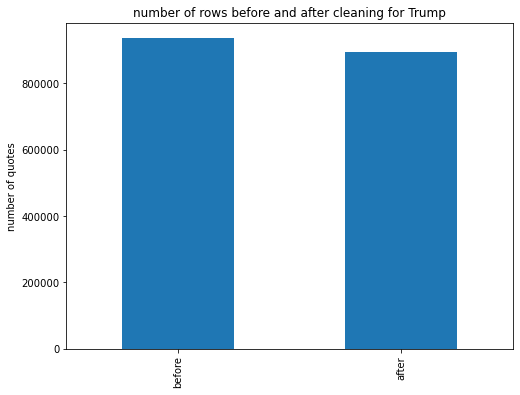

In [32]:
cleaning_results(n_rows_before_cleaning, n_rows_after_cleaning, 'Trump')

As we can see from the plot there are a few sentences that we cleaned, the majority of them was already about Donald Trump (not about his family) and not said by Trump himself.

The following function is Filter chunk by number of qids. Since it is not possible to identify authors with quotes that have multiple qids and for our future analysis we are interested also in authors (their features such as age, gender,...), we filter the quotes found to keep just the quotes whose speaker has a single qid.

In [21]:
def filter_chunk_by_number_of_qids(initial_chunk, qid_number):
    return initial_chunk[initial_chunk["qids"].str.len() == 1]

In [34]:
df_Trump = filter_chunk_by_number_of_qids(df_Trump, 1)

df_Trump

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
888,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E
1521,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E
3257,2015-07-21-047379,I'm sure the Republicans are enjoying Mr. Trum...,President Barack Obama,[Q76],2015-07-21 15:18:20,205,"[[President Barack Obama, 0.6523], [None, 0.19...",[http://azdailysun.com/entertainment/televisio...,E
3819,2015-07-22-051864,"it in particular thrives on theater, which Tru...",Frank Bruni,[Q1443006],2015-07-22 13:33:11,1,"[[Frank Bruni, 0.8479], [None, 0.1246], [Donal...",[http://www.adweek.com/tvnewser/bob-kerrey-on-...,E
4261,2015-07-14-074352,it was appalling to hear Donald Trump describe...,Hillary Clinton,[Q6294],2015-07-14 08:40:17,1,"[[Hillary Clinton, 0.8129], [None, 0.1175], [B...",[http://www.bloomberg.com/politics/articles/20...,E
...,...,...,...,...,...,...,...,...,...
5243971,2020-04-05-029136,To say that I'm infuriated with the recent act...,Dwight Ball,[Q5318112],2020-04-05 23:11:52,1,"[[Dwight Ball, 0.6293], [None, 0.3336], [Justi...",[https://www.cbc.ca/news/politics/trudeau-will...,E
5243994,2020-02-05-103219,Trump offends and disrespects the Venezuelan p...,Jorge Arreaza,[Q6623799],2020-02-05 00:00:00,11,"[[Jorge Arreaza, 0.9164], [None, 0.0726], [Pre...",[https://www.rawstory.com/2020/02/imwithfred-t...,E
5243996,2020-03-13-071475,"Trump tried to mitigate the issue, saying it i...",Hassan Nasrallah,[Q181182],2020-03-13 22:15:06,1,"[[Hassan Nasrallah, 0.922], [None, 0.0741], [P...",[http://israelnationalnews.com/News/News.aspx/...,E
5243997,2020-03-15-037086,Trump's do-over approach -- he unlocked $50 bi...,Newt Gingrich,[Q182788],2020-03-15 00:00:00,40,"[[Newt Gingrich, 0.5146], [None, 0.3958], [Don...",[http://uspolitics.einnews.com/article/5120893...,E


Save trump dataset

In [36]:
# we save it (checkpoint)
df_Trump.to_pickle('df_Trump_cleaned.pkl')
del(df_Trump) #we don't want to store it in memory

### We filter the dataset looking for the quotes about Hillary Cllinton

We repeat the same for Clinton

In [ ]:
for year in years_list:
    one_df_Clinton = filter_dataframe("Clinton", year)
    one_df_Clinton.to_pickle('df_Clinton'+year+'.pkl')
    print('i finished one file')

Now we concatenate the dataframe together

In [28]:
list_df_Clinton = []
for year in years_list:
    one_df_Clinton = pd.read_pickle('df_Clinton'+year+'.pkl')
    list_df_Clinton.append(one_df_Clinton)
df_Clinton = pd.concat(list_df_Clinton)

In [29]:
df_Clinton.to_pickle('df_Clinton.pkl')

In [30]:
df_Clinton = pd.read_pickle('df_Clinton.pkl')

In [31]:
n_rows_before_cleaning = df_Clinton.shape[0]

In [32]:
#We look for Clinton Aliases

count = 0
for el in speaker_attributes['aliases']:
    count=count+1
    if type(el) == np.ndarray:
        if ('Hillary Rodham Clinton' in el):
            Clinton_aliases = el
            print(Clinton_aliases)

['Hillary Rodham Clinton' 'Hillary Rodham' 'Hillary Diane Rodham Clinton'
 'Hillary R. Clinton' 'First Lady Hillary Rodham Clinton'
 'First Lady Hillary Clinton' 'First Lady Clinton' 'Hillary Diane Rodham']


In [33]:
df_Clinton = removing_not_inherent_quotes(['William Jefferson Clinton', 'William J. Clinton', 'Bill Clinton',
                                        'William Clinton', 'President Clinton', 'President Bill Clinton', 
                                        'George William Clinton'], 
                                        df_Clinton, Clinton_aliases)

In [34]:
n_rows_after_cleaning = df_Clinton.shape[0]

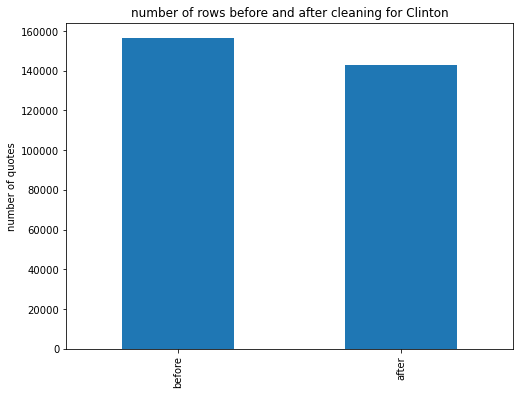

In [35]:
cleaning_results(n_rows_before_cleaning, n_rows_after_cleaning, 'Clinton')

Even in this case we cleaned a few sentences with respect to the total number as we can see in the plot above.

In [36]:
df_Clinton= filter_chunk_by_number_of_qids(df_Clinton, 1) #we filter again to have just the speaker with 1 qid, so that we can merge later

df_Clinton

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
26,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E
784,2015-10-01-005722,An email included in the latest tranche of Cli...,Hillary Clinton,[Q6294],2015-10-01 14:56:48,2,"[[Hillary Clinton, 0.5675], [None, 0.2957], [A...",[http://feeds.foxnews.com/~r/foxnews/politics/...,E
888,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E
6930,2015-10-22-051493,If [ Democratic presidential candidate former ...,Marco Rubio,[Q324546],2015-10-22 20:04:16,1,"[[Marco Rubio, 0.93], [None, 0.0685], [Hillary...",[http://breitbart.com/video/2015/10/22/rubio-i...,E
7374,2015-12-31-032035,I'm electable. I was elected in a purple state...,Jeb Bush,[Q221997],2015-12-31 03:29:00,7,"[[Jeb Bush, 0.8392], [None, 0.0925], [Hillary ...",[http://www.postandcourier.com/article/2015123...,E
...,...,...,...,...,...,...,...,...,...
5222109,2020-03-06-025712,"I think that would have been a mistake, becaus...",Jennifer Palmieri,[Q18209402],2020-03-06 14:38:07,1,"[[Jennifer Palmieri, 0.9117], [None, 0.056], [...",[https://www.rollingstone.com/politics/politic...,E
5231803,2020-01-18-006266,"Chief Justice Rehnquist, when he presided over...",Dick Durbin,[Q434804],2020-01-18 05:01:08,1,"[[Dick Durbin, 0.898], [None, 0.079], [Charlie...",[https://www.washingtonexaminer.com/news/impea...,E
5235860,2020-01-06-061256,The main difference between Lindsey and his De...,David Woodard,[Q1177254],2020-01-06 12:00:30,6,"[[David Woodard, 0.7544], [None, 0.1797], [Lin...",[http://chron.com/entertainment/article/How-Li...,E
5235869,2020-04-09-052373,The model of Obama asking Bush and Clinton to ...,Bill Haslam,[Q862186],2020-04-09 23:04:21,1,"[[Bill Haslam, 0.905], [None, 0.0837], [Barack...",[http://www.nytimes.com/2020/04/09/us/politics...,E


In [37]:
df_Clinton.to_pickle('df_Clinton_cleaned.pkl')

### Conclusions

In the following notebook we have now created two pickle files df_Trump_cleaned and df_Clinton_cleaned which contain all the quotes about Donald Trump/Hillary Clinton whose speaker is not Trump/Clinton himself/herself and whose speaker has just a single qid (so that we can have unique information on it).
In milestone 3 we don't exclude the possibility to apply the same filtering process to other politicians (Biden and/or Obama) if needed for a better understanding of the American political scene. However, the process would be exactly the same and the pipeline is ready.